In [2]:


from tensorflow.python import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten , Input, MaxPooling2D
from keras import backend as K
from keras import datasets

from keras import optimizers
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import datetime

In [4]:
df = pd.DataFrame()

# open CAISO_NORTH_2022-0X_MOER.csv
for i in range(1, 5):
    filename = "CAISO_NORTH_2022-0{}_MOER.xlsx".format(i)
    temp = pd.read_excel(filename, header=0, parse_dates=True).squeeze("columns")
    df = pd.concat([df, temp], axis=0)
df

,timestamp,MOER,MOER version,frequency
0,2022-01-01T00:00:00+00:00,993,3,300
1,2022-01-01T00:05:00+00:00,1001,3,300
2,2022-01-01T00:10:00+00:00,987,3,300
3,2022-01-01T00:15:00+00:00,990,3,300
4,2022-01-01T00:20:00+00:00,989,3,300
...,...,...,...,...
8635,2022-04-30T23:35:00+00:00,42,3,300
8636,2022-04-30T23:40:00+00:00,42,3,300
8637,2022-04-30T23:45:00+00:00,41,3,300
8638,2022-04-30T23:50:00+00:00,41,3,300


In [6]:
#drop moer and frequency columnn
data = df.drop(['MOER version', 'frequency'], axis=1)

#timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

#replace data that has MOER less than 750 and replace with medium value of dataset
data['MOER'] = data['MOER'].mask(data['MOER'] < 750, data['MOER'].median())


In [7]:
#create new column for day of week and hour of day from timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek+1
data['time_of_day'] = data['timestamp'].dt.hour
data['month'] = data['timestamp'].dt.month
data.shape

(34560, 5)

In [8]:
time = data.time_of_day.values.reshape(-1, 1)
day = data.day_of_week.values.reshape(-1, 1)
month = data.month.values.reshape(-1, 1)

In [9]:
# define the input shape of the FFNN
input_shape = (3,)

# create the FFNN model
model = keras.Sequential([
    keras.layers.Dense(units=2056, activation='sigmoid', input_shape=input_shape),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1)
])

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

X = np.hstack((time,day,month))
y = data.MOER.values.reshape(-1, 1)

#split data into training and testing
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
# train the model on the example data
model.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_test, y_test))


Epoch 1/100
864/864 [==============================] - 3s 3ms/step - loss: 51026.0039 - accuracy: 0.0000e+00 - val_loss: 7405.2847 - val_accuracy: 0.0000e+00
Epoch 2/100
864/864 [==============================] - 2s 3ms/step - loss: 2729.2634 - accuracy: 0.0000e+00 - val_loss: 4539.2739 - val_accuracy: 0.0000e+00
Epoch 3/100
864/864 [==============================] - 2s 3ms/step - loss: 2551.3096 - accuracy: 0.0000e+00 - val_loss: 3661.3496 - val_accuracy: 0.0000e+00
Epoch 4/100
864/864 [==============================] - 2s 3ms/step - loss: 2511.1985 - accuracy: 0.0000e+00 - val_loss: 3394.3286 - val_accuracy: 0.0000e+00
Epoch 5/100
864/864 [==============================] - 3s 3ms/step - loss: 2484.2000 - accuracy: 0.0000e+00 - val_loss: 3660.2583 - val_accuracy: 0.0000e+00
Epoch 6/100
864/864 [==============================] - 2s 3ms/step - loss: 2474.4185 - accuracy: 0.0000e+00 - val_loss: 4659.8511 - val_accuracy: 0.0000e+00
Epoch 7/100
864/864 [==============================] - 2s

4.572724426912559

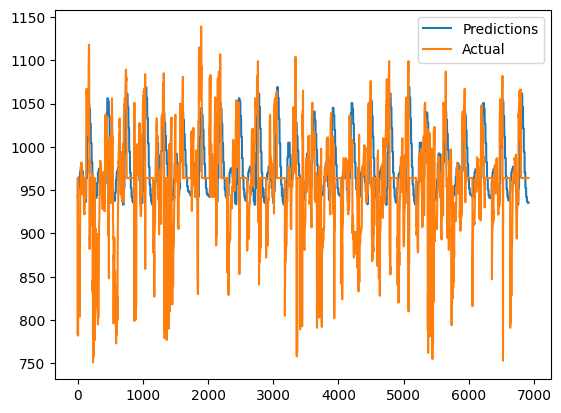

In [11]:
# use the model to make predictions on new data
predictions = model.predict(X_test)

#plot predictions vs actual
plt.plot(predictions, label='Predictions')
plt.plot(y_test, label='Actual')
plt.legend()

#compute MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, predictions)